In [29]:
import os
import torch
import pickle
import re
import numpy as np
import time
import joblib
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import hmax.pytorch_hmax.hmax as hmax
import matplotlib.patches as mpatches

from datetime import datetime
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.exceptions import NotFittedError
from tqdm import tqdm 
from PIL import Image
from joblib import parallel_backend

from Dataset import CrossFinDataset, MullerLyerDataset

# Components of the HMAX model, an introduction

## S1 layer

These are the first simple units in the model, that perform a 2D convolution with Gabor filters. There are 4 Gabor filters, oriented at 90, -45, 0 and 45 degrees. Each filter is defined at 16 different scales. The s1 variable is a list of length 16, containing the output at each scale. Each element is a NumPy array of shape `#images x #rotations x image_height x image_width` that is the result of the convolution operation.

## What is a Gabor Filter?

The Gabor filter, named after Dennis Gabor, is a linear filter used in myriad image processing applications for edge detection, texture analysis, feature extraction, etc. Gabor filters are special classes of bandpass filters, i.e., they allow a certain ‘band’ of frequencies and reject the others. A Gabor filter can be viewed as a sinusoidal signal of particular frequency and orientation, modulated by a Gaussian wave. In short, it extracts the local signals in the image domain in a way that is sensitive to a certain orientation (angle). Below shows how it is derived.

**Step 1: Gaussian Envelope**

To achieve optimal spatial and frequency localization, start with a 2D Gaussian function:

$$
G_{\text{env}}(x, y) = \exp\left(-\frac{x^2 + y^2}{2\sigma^2}\right)
$$

**Step 2: Frequency Selectivity**

Modulate the Gaussian with a cosine function to introduce a preferred spatial frequency:

$$
G(x, y) = G_{\text{env}}(x, y) \cdot \cos\left(2\pi \frac{x}{\lambda} + \psi\right)
$$

**Step 3: Orientation Tuning**

Define the rotated coordinates to allow the filter to be oriented at an angle ($\theta$):

$$
\begin{aligned}
x' &= x \cos \theta + y \sin \theta, \\
y' &= -x \sin \theta + y \cos \theta.
\end{aligned}
$$

Optionally, include an aspect ratio ($\gamma$) to adjust the elliptical shape of the envelope:

$$
G_{\text{env}}(x, y) = \exp\left(-\frac{x'^2 + \gamma^2 y'^2}{2\sigma^2}\right)
$$

**Step 4: Filter Formulation**

Combine all the components to get the full Gabor filter:

$$
G(x, y; \lambda, \theta, \psi, \sigma, \gamma) = \exp\left(-\frac{(x \cos \theta + y \sin \theta)^2 + \gamma^2 (-x \sin \theta + y \cos \theta)^2}{2\sigma^2}\right) \cos\left(2\pi \frac{x \cos \theta + y \sin \theta}{\lambda} + \psi\right)
$$


# Load data

In [2]:
TRAINING_DATA_DIR = 'training_data' # Subfolder with images
UNIVERSAL_PATCH_SET_PATH = 'hmax/pytorch_hmax/universal_patch_set.mat' 
BATCH_SIZE = 32         
IMG_SIZE = 256         
TEST_SPLIT_FRACTION = 0.2 
RANDOM_SEED = 42
torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

In [3]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"Using GPU: {torch.cuda.get_device_name(0)}")
else:
    device = torch.device("cpu")
    print("Using CPU")

print("\n--- Preparing Data ---")
data_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)) # Normalize for single channel
])

try:
    full_dataset = CrossFinDataset(data_dir=TRAINING_DATA_DIR,
                                   transform=data_transform)
except Exception as e:
    print(f"Failed to load dataset: {e}")
    exit(1)

dataset_size = len(full_dataset)
print(f"Total samples found: {dataset_size}")

all_labels = [p['label'] for p in full_dataset.params]

if dataset_size < 2:
    print("Error: Dataset too small to split.")
    exit(1)

if len(set(all_labels)) < 2:
    print("Warning: Only one class present; using random split.")
    train_indices, test_indices = train_test_split(
        list(range(dataset_size)),
        test_size=TEST_SPLIT_FRACTION,
        random_state=RANDOM_SEED
    )
else:
    train_indices, test_indices = train_test_split(
        list(range(dataset_size)),      # <-- only the indices to split
        test_size=TEST_SPLIT_FRACTION,
        random_state=RANDOM_SEED,
        stratify=all_labels             # <-- stratify by label list
    )

print(f"Training / Testing: {len(train_indices)} / {len(test_indices)}")

train_subset = Subset(full_dataset, train_indices)
test_subset  = Subset(full_dataset, test_indices)

num_workers = min(4, (os.cpu_count() or 1) // 2)
train_feature_loader = DataLoader(train_subset,
                          batch_size=BATCH_SIZE,
                          shuffle=True,
                          num_workers=num_workers)
test_feature_loader = DataLoader(test_subset,
                         batch_size=BATCH_SIZE,
                         shuffle=False,
                         num_workers=num_workers)

Using GPU: NVIDIA GeForce RTX 4070 Laptop GPU

--- Preparing Data ---
Found 10000 CrossFin images in training_data
Total samples found: 10000
Training / Testing: 8000 / 2000


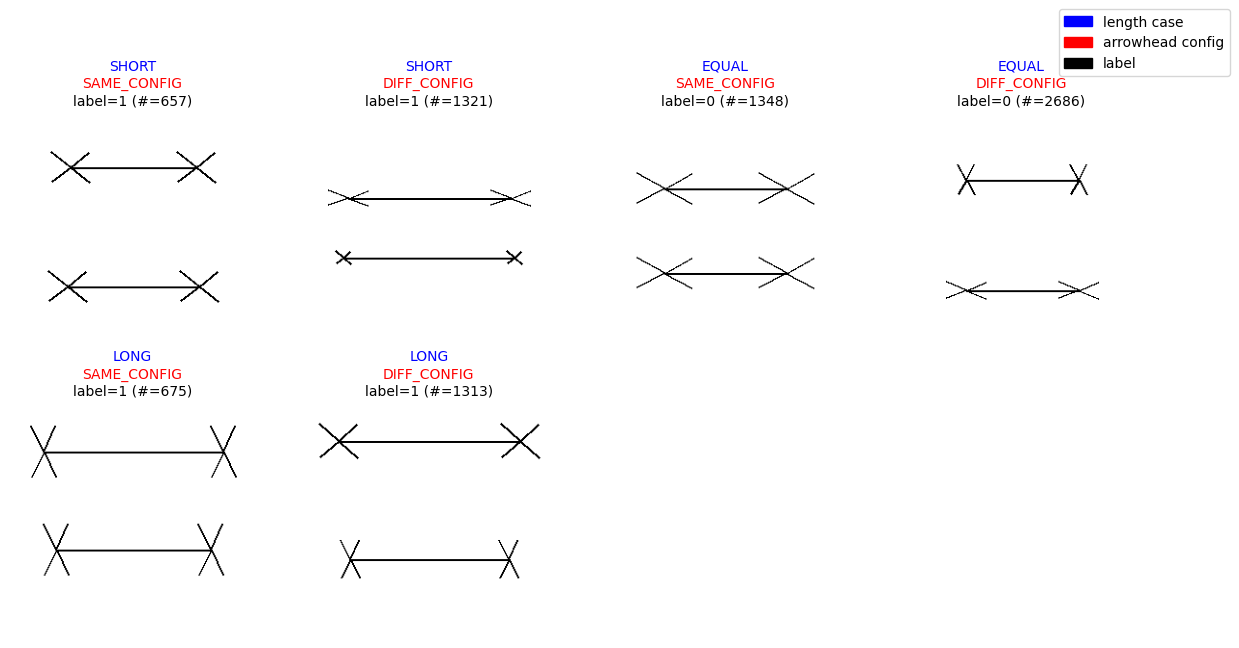

In [ ]:
counts = {}
combos = {}
for idx in train_indices:
    p   = full_dataset.params[idx]
    key = (p['length_case'], p['fin_case'], p['label'])
    counts[key] = counts.get(key, 0) + 1
    if key not in combos:
        combos[key] = idx

length_order = ['SHORT', 'EQUAL', 'LONG']
fin_order    = ['SAME_CONFIG', 'DIFF_CONFIG']
labels       = sorted({k[2] for k in combos.keys()})

sorted_keys = sorted(
    combos.keys(),
    key=lambda x: (length_order.index(x[0]),
                   fin_order.index(x[1]),
                   labels.index(x[2]))
)

n = len(sorted_keys)
ncols, nrows = 4, (n + 3) // 4
fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*3, nrows*3))
axes = axes.flatten()

for ax, key in zip(axes, sorted_keys):
    idx = combos[key]
    img_tensor, _ = full_dataset[idx]
    img = img_tensor * 0.5 + 0.5
    np_img = img.squeeze(0).cpu().numpy()
    ax.imshow(np_img, cmap='gray')
    ax.axis('off')

    length, config, lbl = key
    ax.text(0.5, 1.12, length,
            color='blue', fontsize=10,
            ha='center', va='bottom',
            transform=ax.transAxes)
    ax.text(0.5, 1.05, config,
            color='red', fontsize=10,
            ha='center', va='bottom',
            transform=ax.transAxes)
    ax.text(0.5, 0.98, f"label={lbl} (#={counts[key]})",
            color='black', fontsize=10,
            ha='center', va='bottom',
            transform=ax.transAxes)

for ax in axes[len(sorted_keys):]:
    ax.axis('off')

blue_patch  = mpatches.Patch(color='blue',  label='length case')
red_patch   = mpatches.Patch(color='red',   label='arrowhead config')
black_patch = mpatches.Patch(color='black', label='label')
fig.legend(handles=[blue_patch, red_patch, black_patch],
           loc='lower right', bbox_to_anchor=(1.05, 0.95))

plt.tight_layout()
plt.show()

In [16]:
print("\n--- Initializing HMAX Model ---")
try:
    if not os.path.exists(UNIVERSAL_PATCH_SET_PATH):
         raise FileNotFoundError(f"Cannot find Universal Patch Set at: {UNIVERSAL_PATCH_SET_PATH}. Please check the path.")
         
    hmax_model = hmax.HMAX(universal_patch_set=UNIVERSAL_PATCH_SET_PATH).to(device) 
    hmax_model.eval() # Set to evaluation mode
    print("HMAX model initialized successfully.")
except (FileNotFoundError, KeyError, RuntimeError, Exception) as e:
    print(f"Error initializing HMAX model: {e}")
    exit()


--- Initializing HMAX Model ---
HMAX model initialized successfully.


In [ ]:
def extract_hmax_features(dataloader, model, device):
    """Extracts HMAX C2 features for all data in the dataloader."""
    all_features = []
    all_labels = []
    model.eval() 
    with torch.no_grad(): 
        for images, labels_batch in tqdm(dataloader, desc="Extracting Features"):
            images = images.to(device)
            features_batch = model(images) 
            
            all_features.append(features_batch.cpu().numpy())

            all_labels.append(labels_batch.cpu().numpy()) 

    # Concatenate features and labels from all batches
    if not all_features: 
         print("Warning: No features extracted. Dataloader might be empty.")
         return np.array([]), np.array([])
         
    all_features = np.concatenate(all_features, axis=0)
    all_labels = np.concatenate(all_labels, axis=0)
    
    print(f"Extracted features shape: {all_features.shape}")
    print(f"Extracted labels shape: {all_labels.shape}")
    return all_features, all_labels

In [18]:
""" BEFORE RUNNING THIS CELL, FILL IN THE LOGISTICS BELOW """
feature_save_path = 'run_1_features.npz'    # Path to save extracted features or to load from
features_loaded_from_file = True           # Load features if true
""" ONLY RUN THIS CELL AFTER THINKING THROUGH THE LOGISTICS """

if os.path.exists(feature_save_path):
    print(f"--- Found pre-extracted features file: {feature_save_path} ---")
    try:
        print("Loading features from file...")
        start_time = time.time()
        data = np.load(feature_save_path)
        X_train_hmax = data['X_train']
        y_train_hmax = data['y_train']
        X_test_hmax = data['X_test']
        y_test_hmax = data['y_test']

        if X_train_hmax.size > 0 and X_test_hmax.size > 0:
             features_loaded_from_file = True
             print(f"Features loaded successfully in {time.time() - start_time:.2f} seconds.")
             print(f"Loaded Training features shape: {X_train_hmax.shape}")
             print(f"Loaded Testing features shape: {X_test_hmax.shape}")
        else:
             print("Loaded file seems to contain empty arrays. Re-extracting...")
             features_loaded_from_file = False
    except Exception as e:
        print(f"Error loading features from {feature_save_path}: {e}")
        print("Will attempt to re-extract features.")
        features_loaded_from_file = False

if not features_loaded_from_file:
    print("\n--- Extracting Training Features ---")
    start_time = time.time()

    X_train_hmax, y_train_hmax = extract_hmax_features(train_feature_loader, hmax_model, device)
    print(f"Training feature extraction took {time.time() - start_time:.2f} seconds")

    print("\n--- Extracting Testing Features ---")
    start_time = time.time()
    X_test_hmax, y_test_hmax = extract_hmax_features(test_feature_loader, hmax_model, device)
    print(f"Testing feature extraction took {time.time() - start_time:.2f} seconds")

    if X_train_hmax.size > 0 and X_test_hmax.size > 0:
        print(f"\n--- Saving Extracted Features to {feature_save_path} ---")
        try:
            start_time = time.time()
            np.savez_compressed(feature_save_path, 
                               X_train=X_train_hmax, y_train=y_train_hmax,
                               X_test=X_test_hmax, y_test=y_test_hmax)
            print(f"Features saved successfully in {time.time() - start_time:.2f} seconds.")
        except Exception as e:
            print(f"Error saving features to {feature_save_path}: {e}")
    else:
        print("Error: Feature extraction resulted in empty arrays. Cannot save.")
        exit()

--- Found pre-extracted features file: run_1_features.npz ---
Loading features from file...
Features loaded successfully in 0.82 seconds.
Loaded Training features shape: (8000, 8, 400)
Loaded Testing features shape: (2000, 8, 400)


In [19]:
if X_train_hmax.size == 0 or X_test_hmax.size == 0:
    print("Error: Feature arrays are empty after loading or extraction.")
    exit()

print("\n--- Reshaping extracted features for SVM ---")

print(f"Original X_train_hmax shape: {X_train_hmax.shape}")
print(f"Original X_test_hmax shape: {X_test_hmax.shape}")

if X_train_hmax.ndim == 3:
    n_train_samples = X_train_hmax.shape[0]
    
    X_train_hmax_2d = X_train_hmax.reshape(n_train_samples, -1) 
    print(f"Reshaped X_train_hmax_2d shape: {X_train_hmax_2d.shape}")
else:
    print("Training features already seem to be 2D or other. Using as is.")
    X_train_hmax_2d = X_train_hmax # Use original if not 3D

if X_test_hmax.ndim == 3:
    n_test_samples = X_test_hmax.shape[0]
    X_test_hmax_2d = X_test_hmax.reshape(n_test_samples, -1)
    print(f"Reshaped X_test_hmax_2d shape: {X_test_hmax_2d.shape}")
else:
    print("Testing features already seem to be 2D or other. Using as is.")
    X_test_hmax_2d = X_test_hmax # Use original if not 3D



--- Reshaping extracted features for SVM ---
Original X_train_hmax shape: (8000, 8, 400)
Original X_test_hmax shape: (2000, 8, 400)
Reshaped X_train_hmax_2d shape: (8000, 3200)
Reshaped X_test_hmax_2d shape: (2000, 3200)


In [34]:
svc_dir     = f"svc_results_{datetime.now():%Y%m%d_%H%M%S}" # modify if loading trained model
os.makedirs(svc_dir, exist_ok=True)
model_path      = os.path.join(svc_dir, "best_svc.joblib")
cv_results_path = os.path.join(svc_dir, "svc_cv_results.csv")
summary_path    = os.path.join(svc_dir, "summary.txt")
report_path     = os.path.join(svc_dir, "classification_report.txt")
linear_SVM = True

# Load existing model
svc_loaded = False
if os.path.exists(model_path):
    try:
        svc = joblib.load(model_path)
        _ = svc.predict(X_train_hmax_2d[[0]])  # sanity check
        print("Loaded existing SVC from", model_path)
        svc_loaded = True
    except Exception as e:
        print("Existing SVC not usable:", e)

# If no valid model, run grid search
if not svc_loaded:
    print("\n--- Grid Searching SVC ---")
    if linear_SVM:
        print("Using linear SVC")
        base_svc = LinearSVC(random_state=RANDOM_SEED,   
                             dual=False) 
        param_grid = {
            'C': [0.1, 1, 10],
            'tol': [1e-4, 1e-3, 1e-2],
            'max_iter': [10000],
            'class_weight': [None, 'balanced']
        }
    else:
        print("Using non-linear SVC")
        base_svc = SVC(random_state=RANDOM_SEED)
        param_grid = {
        'C':      [0.01, 0.1, 1, 10, 100],
        'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
        'gamma':  ['scale', 'auto'],
        'degree': [2, 3]   
        }
    grid = GridSearchCV(
        estimator=base_svc,
        param_grid=param_grid,
        cv=5,
        scoring='accuracy',
        verbose=2,
        n_jobs=1
    )

    start = time.time()
    grid.fit(X_train_hmax_2d, y_train_hmax)
    print(f"Grid search done in {time.time() - start:.1f}s")

    svc = grid.best_estimator_

    # save artifacts
    joblib.dump(svc, model_path)
    pd.DataFrame(grid.cv_results_).to_csv(cv_results_path, index=False)
    with open(summary_path, 'w') as f:
        f.write("=== SVC Grid Search Summary ===\n")
        f.write(f"Best params: {grid.best_params_}\n")
        f.write(f"Best CV accuracy: {grid.best_score_:.4f}\n")

# 4) Evaluate & save reports
print("\n--- Evaluating & Saving Results ---")
y_pred_tr = svc.predict(X_train_hmax_2d)
y_pred_te = svc.predict(X_test_hmax_2d)

acc_tr = accuracy_score(y_train_hmax, y_pred_tr)
acc_te = accuracy_score(y_test_hmax,  y_pred_te)

with open(summary_path, 'a') as f:
    f.write(f"\nTrain acc: {acc_tr:.4f}\nTest  acc: {acc_te:.4f}\n")

report = classification_report(
    y_test_hmax, y_pred_te,
    target_names=['Equal (0)','Unequal (1)'],
    zero_division=0
)
with open(report_path, 'w') as f:
    f.write("=== Classification Report ===\n\n")
    f.write(report)

print(f"All artifacts saved under {svc_dir}")


--- Grid Searching SVC ---
Using linear SVC
Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV] END C=0.1, class_weight=None, max_iter=10000, tol=0.0001; total time=  16.7s
[CV] END C=0.1, class_weight=None, max_iter=10000, tol=0.0001; total time=  16.9s
[CV] END C=0.1, class_weight=None, max_iter=10000, tol=0.0001; total time=  20.4s
[CV] END C=0.1, class_weight=None, max_iter=10000, tol=0.0001; total time=  25.3s
[CV] END C=0.1, class_weight=None, max_iter=10000, tol=0.0001; total time=  25.7s
[CV] END C=0.1, class_weight=None, max_iter=10000, tol=0.001; total time=  16.1s
[CV] END C=0.1, class_weight=None, max_iter=10000, tol=0.001; total time=  19.0s
[CV] END C=0.1, class_weight=None, max_iter=10000, tol=0.001; total time=  14.9s
[CV] END C=0.1, class_weight=None, max_iter=10000, tol=0.001; total time=  13.1s
[CV] END C=0.1, class_weight=None, max_iter=10000, tol=0.001; total time=  15.5s
[CV] END .C=0.1, class_weight=None, max_iter=10000, tol=0.01; total time=   9.0

## Visualization - TRAINING STAGE

In [35]:
model_path = "svc_results_20250513_003527/best_svc.joblib"
svc = joblib.load(model_path)

y_pred = svc.predict(X_test_hmax_2d)
y_true = y_test_hmax

C:\Users\dongn\AppData\Local\Temp\ipykernel_15420\2093587549.py:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=by_label, x='label', y='Accuracy', palette='crest', ax=ax)


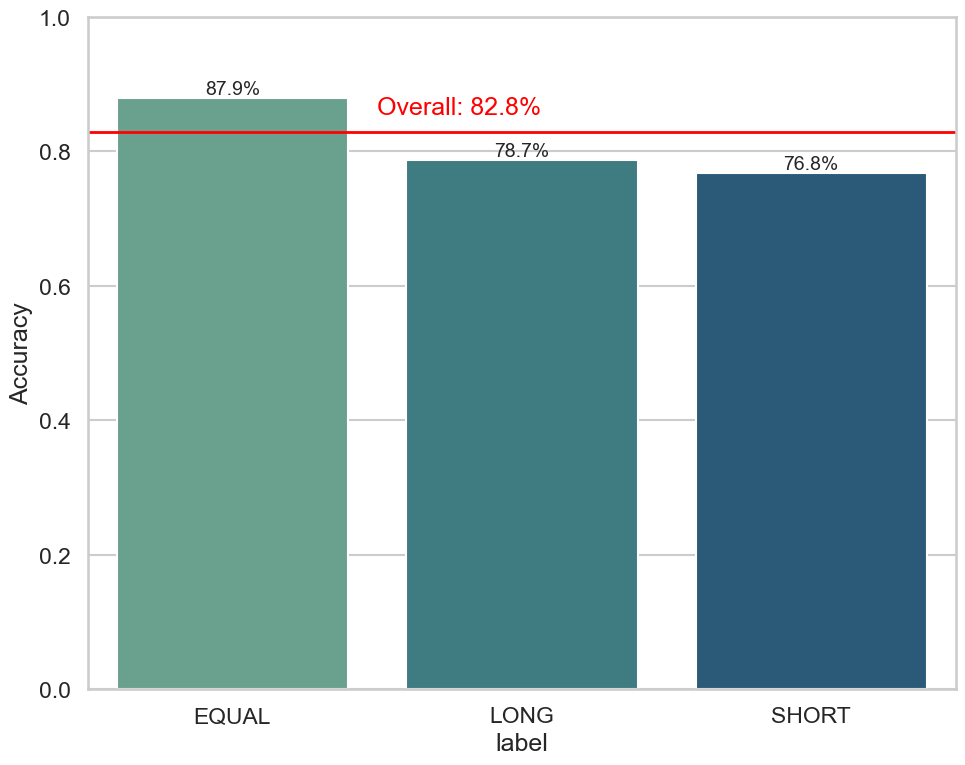

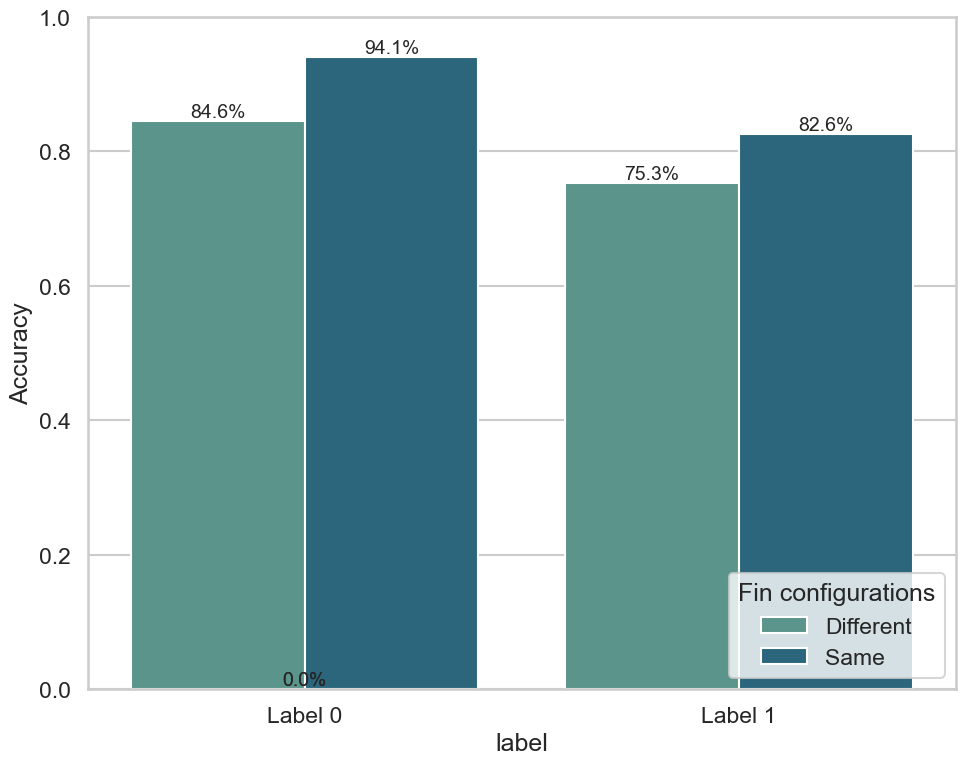



             bin  Accuracy
0  (9.999, 14.0]  0.910112
1   (14.0, 17.0]  0.967742
2   (17.0, 21.0]  0.983871
3   (21.0, 27.6]  0.956522
4   (27.6, 35.0]  0.901408


C:\Users\dongn\AppData\Local\Temp\ipykernel_15420\2093587549.py:77: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby('bin')['prediction']
C:\Users\dongn\AppData\Local\Temp\ipykernel_15420\2093587549.py:84: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=table, x='bin', y='Accuracy', palette='viridis', ax=ax)


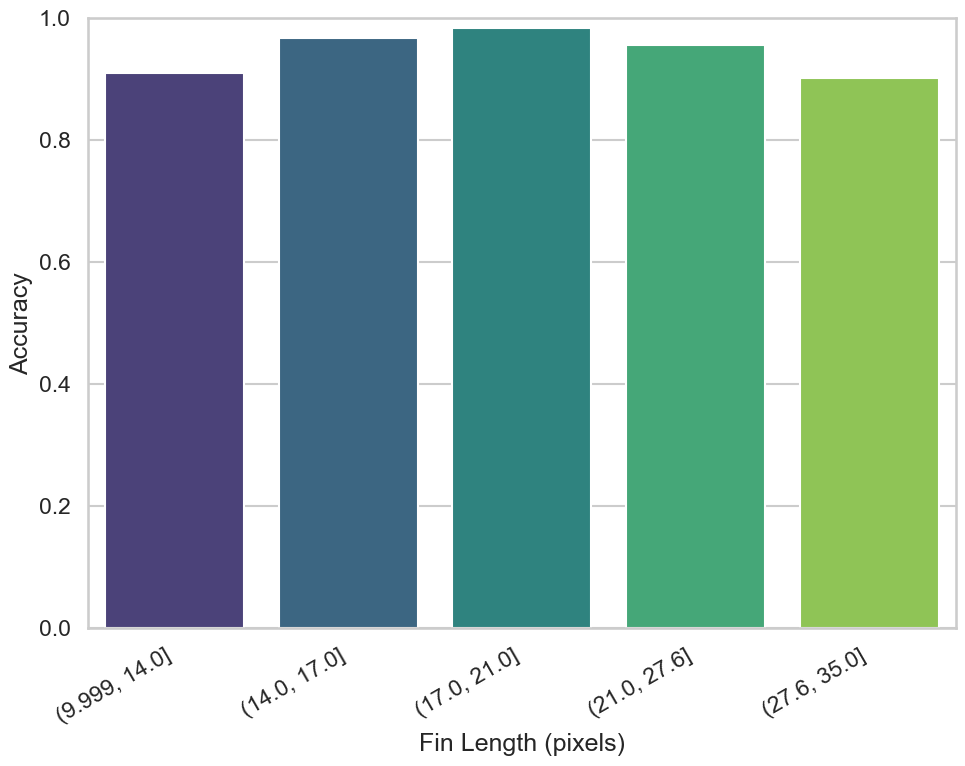

C:\Users\dongn\AppData\Local\Temp\ipykernel_15420\2093587549.py:77: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby('bin')['prediction']
C:\Users\dongn\AppData\Local\Temp\ipykernel_15420\2093587549.py:84: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=table, x='bin', y='Accuracy', palette='viridis', ax=ax)




              bin  Accuracy
0  (14.999, 27.0]  0.986301
1    (27.0, 41.8]  0.955882
2    (41.8, 51.0]  0.944444
3    (51.0, 62.0]  0.957143
4    (62.0, 75.0]  0.857143


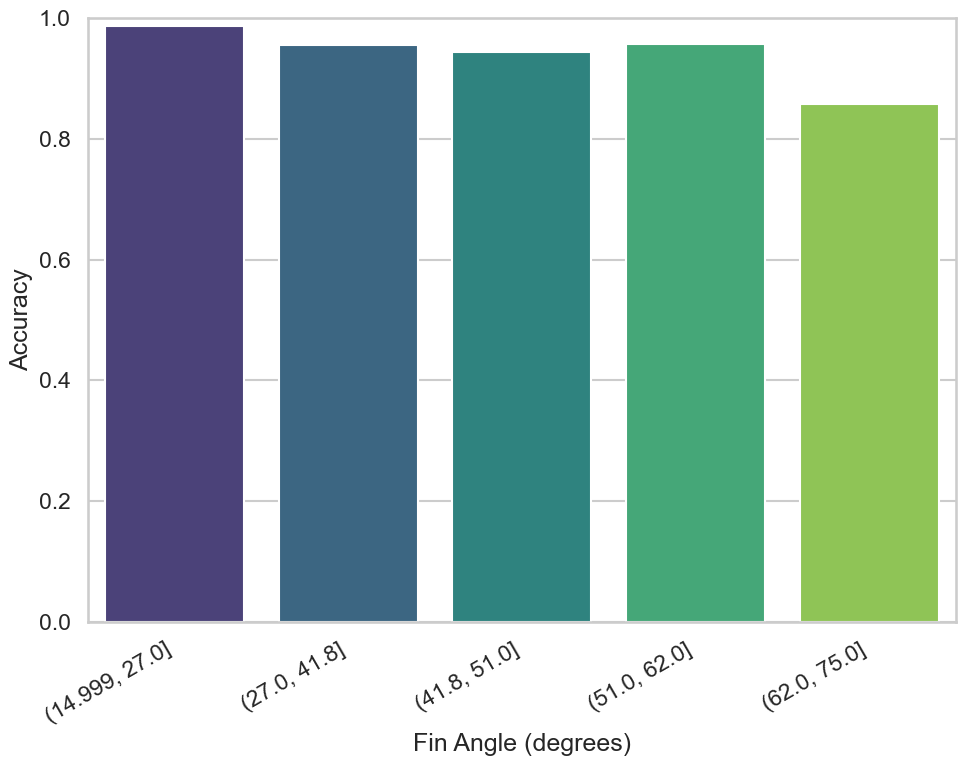



                  bin  Accuracy
0  (-153.001, -121.0]  0.798100
1    (-121.0, -107.0]  0.817949
2     (-107.0, -97.0]  0.856777
3      (-97.0, -83.0]  0.822222
4      (-83.0, -53.0]  0.849873


C:\Users\dongn\AppData\Local\Temp\ipykernel_15420\2093587549.py:77: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby('bin')['prediction']
C:\Users\dongn\AppData\Local\Temp\ipykernel_15420\2093587549.py:84: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=table, x='bin', y='Accuracy', palette='viridis', ax=ax)


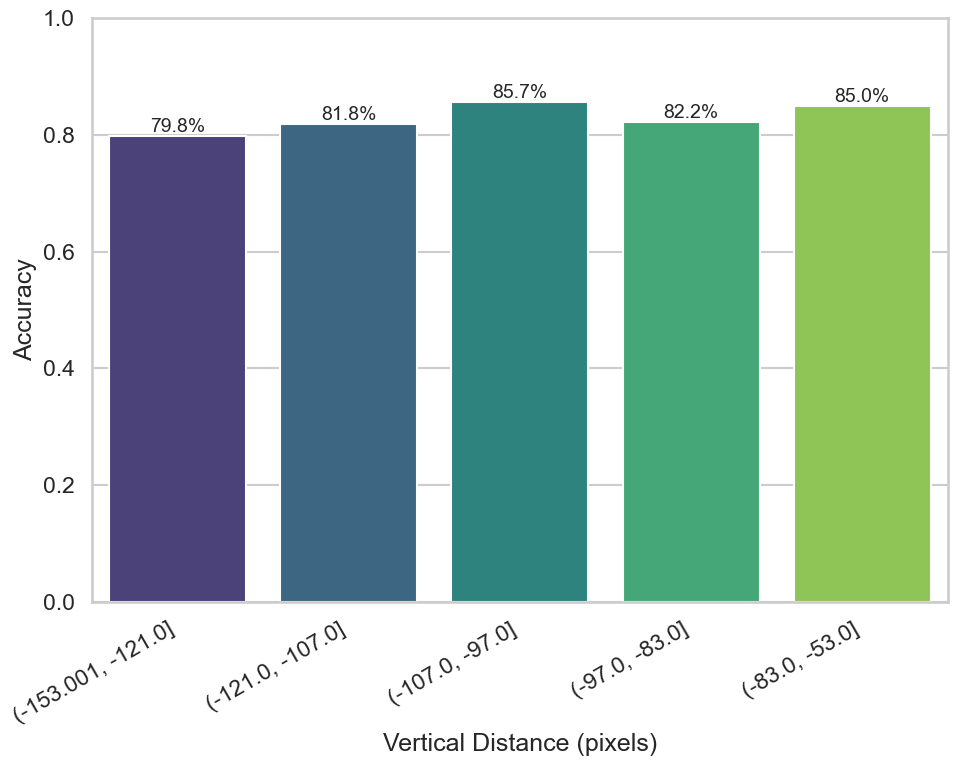



              bin  Accuracy
0  (44.999, 74.0]  0.809756
1   (74.0, 105.0]  0.891626
2  (105.0, 138.2]  0.903553
3  (138.2, 173.0]  0.872038
4  (173.0, 204.0]  0.921875


C:\Users\dongn\AppData\Local\Temp\ipykernel_15420\2093587549.py:77: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby('bin')['prediction']
C:\Users\dongn\AppData\Local\Temp\ipykernel_15420\2093587549.py:84: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=table, x='bin', y='Accuracy', palette='viridis', ax=ax)


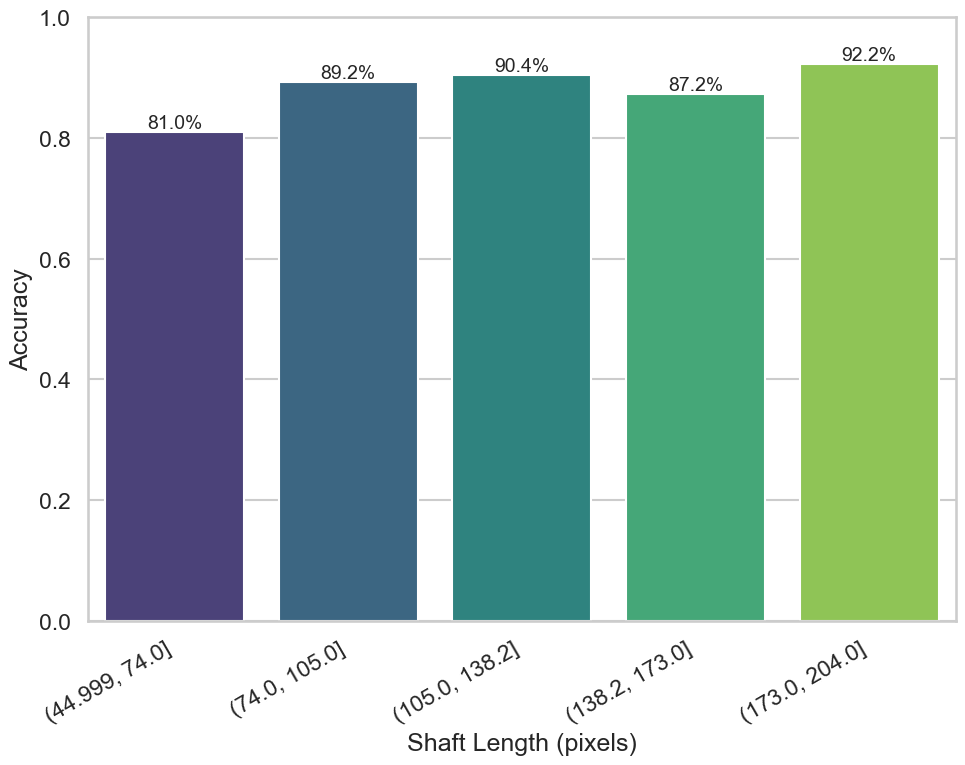


— All plots rendered —


In [ ]:
sns.set_theme(style="whitegrid")
sns.set_context("talk")

# dataframe for plotting
records = []
for pred, true, idx in zip(y_pred, y_test_hmax, test_indices):
    p = full_dataset.params[idx]
    records.append({
        'label':           p['label'],
        'length_case':     p['length_case'],
        'fin_case':        p['fin_case'],
        'top_length':      p['top_length'],
        'top_fin_length':  p['top_fin_length'],
        'top_fin_angle':   p['top_fin_angle'],
        'top_y':           p['top_y'],
        'bottom_y':        p['bottom_y'],
        'prediction':      pred,
        'true_label':      true
    })
df = pd.DataFrame(records)
df['vert_dist'] = df['top_y'] - df['bottom_y'] # vertical distance

# subsets of data classes
subset_same0  = df[(df['label']==0)&(df['fin_case']=='SAME_CONFIG')] # label=0, fin_case=SAME_CONFIG
subset_label0 = df[df['label']==0]                                   # label=0

def annotate_bars(ax, fmt="{:.1%}", y_offset=0.00):
    for p in ax.patches:
        h = p.get_height()
        ax.annotate(fmt.format(h),
                    (p.get_x()+p.get_width()/2, h + y_offset),
                    ha='center', va='bottom', 
                    fontsize=14)

# ==================================================
# Fig. 1: Overall vs Per‐Label accuracy
overall_acc = np.mean(df['prediction']==df['true_label'])
by_label = (
    df.groupby('length_case')['prediction']
      .apply(lambda x: np.mean(x==df.loc[x.index,'true_label']))
      .reset_index(name='Accuracy')
      .assign(label=lambda d: d['length_case'].map({'LONG':'LONG','SHORT':'SHORT', 'EQUAL':'EQUAL'}))
)
fig, ax = plt.subplots(figsize=(10, 8))
sns.barplot(data=by_label, x='label', y='Accuracy', palette='crest', ax=ax)
ax.axhline(overall_acc, color='red', linestyle='-', linewidth=2)
ax.text(0.5, overall_acc+0.02, f"Overall: {overall_acc:.1%}",
        color='red', ha='left', va='bottom')
ax.set(ylim=(0,1), title="")
annotate_bars(ax)
plt.tight_layout()
plt.show()

# ==================================================
# Fig. 2: Accuracy grouped by Label and fin_case
by_fin = (
    df.groupby(['label','fin_case'])['prediction']
      .apply(lambda x: np.mean(x==df.loc[x.index,'true_label']))
      .reset_index(name='Accuracy')
      .assign(label=lambda d: d['label'].map({0:'Label 0',1:'Label 1'}),
              fin_case=lambda d: d['fin_case'].map({'SAME_CONFIG':'Same','DIFF_CONFIG':'Different'}))
)
fig, ax = plt.subplots(figsize=(10, 8))
sns.barplot(data=by_fin, x='label', y='Accuracy', hue='fin_case',
            palette='crest', ax=ax)
ax.set(ylim=(0,1), title="")
annotate_bars(ax)
ax.legend(title="Fin configurations", loc='lower right')
plt.tight_layout()
plt.show()

# ===================================================
def plot_continuous(data, var, bins, title, xlabel, annotate=True):
    binned = pd.qcut(data[var], q=bins, duplicates='drop')
    table  = (
        data.assign(bin=binned)
            .groupby('bin')['prediction']
            .apply(lambda x: np.mean(x==data.loc[x.index,'true_label']))
            .reset_index(name='Accuracy')
    )
    print(f"\n{title}")
    print(table)
    fig, ax = plt.subplots(figsize=(10,8))
    sns.barplot(data=table, x='bin', y='Accuracy', palette='viridis', ax=ax)
    ax.set(ylim=(0,1), title=title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel("Accuracy")
    plt.setp(ax.get_xticklabels(), rotation=30, ha='right')
    if annotate:
        annotate_bars(ax)
    plt.tight_layout()
    plt.show()

# Fig. 3: Accuracy by Fin Length (label=0, fin_case=SAME_CONFIG)
plot_continuous(
    subset_same0, 'top_fin_length', 5,
    "",
    "Fin Length (pixels)",
    annotate=False
)

# Fig. 4: Accuracy by Top Fin Angle (label=0, fin_case=SAME_CONFIG)
plot_continuous(
    subset_same0, 'top_fin_angle', 5,
    "",
    "Fin Angle (degrees)",
    annotate=False
)

# Fig. 5: Accuracy by Vertical Distance (all labels & configs)
plot_continuous(
    df, 'vert_dist', 5,
    "",
    "Vertical Distance (pixels)"
)

# Fig. 6: Accuracy by Top Length (label=0)
plot_continuous(
    subset_label0, 'top_length', 5,
    "",
    "Shaft Length (pixels)"
)


# RQ1: Does HMAX subject to Illusions? 

In [141]:
from Dataset import MullerLyerDataset

In [ ]:
# --- Configuration ---
ML_DATA_DIR = "test_data" # Directory with Müller-Lyer images
UNIVERSAL_PATCH_SET_PATH = 'hmax/pytorch_hmax/universal_patch_set.mat' 
SVM_MODEL_PATH = "svc_results_20250505_203424/best_svc.joblib" 
BATCH_SIZE = 32 
IMG_SIZE = 256
# NUM_WORKERS = min(4, os.cpu_count() // 2 if os.cpu_count() else 1) 
NUM_WORKERS = 0

if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"Using GPU: {torch.cuda.get_device_name(0)}")
else:
    device = torch.device("cpu")
    print("Using CPU")

ml_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

def custom_ml_collate_fn(batch):
    """
    Custom collate function for MullerLyerDataset.
    Stacks images but keeps parameter dictionaries as a list.
    """
    # batch is a list of tuples: [(image_tensor1, params_dict1), (image_tensor2, params_dict2), ...]
    
    images = [item[0] for item in batch]
    params_list = [item[1] for item in batch] # <-- Keep params as a list of dicts
    
    # Stack images into a batch tensor 
    images_batch = torch.utils.data.default_collate(images) # Safest way to stack

    return images_batch, params_list 

try:
    ml_dataset = MullerLyerDataset(data_dir=ML_DATA_DIR, transform=ml_transform)
    print(f"Actual length of ml_dataset reported: {len(ml_dataset)}") 

    ml_dataloader = DataLoader(ml_dataset,
                               batch_size=BATCH_SIZE,
                               shuffle=False,
                               num_workers=NUM_WORKERS,
                               pin_memory=True, # Keep pin_memory if using GPU
                               collate_fn=custom_ml_collate_fn) # <-- ADD THIS ARGUMENT
except Exception as e:
    print(f"Failed to create Müller-Lyer dataset/loader: {e}")
    exit()

Using GPU: NVIDIA GeForce RTX 4070 Laptop GPU
Scanning directory: test_data
Found 10000 Müller-Lyer images.
Actual length of ml_dataset reported: 10000


In [ ]:
# Load HMAX Model
try:
    if not os.path.exists(UNIVERSAL_PATCH_SET_PATH):
         raise FileNotFoundError(f"HMAX Patch Set not found: {UNIVERSAL_PATCH_SET_PATH}")
    hmax_model = hmax.HMAX(universal_patch_set=UNIVERSAL_PATCH_SET_PATH).to(device)
    hmax_model.eval()
    print("HMAX model loaded successfully.")
    # hmax_model = torch.compile(hmax_model)
    # hmax_model = hmax_model.to(device) #
    # hmax_model.eval()
except Exception as e:
    print(f"Error loading HMAX model: {e}")
    exit()

# Load SVM Model
try:
    if not os.path.exists(SVM_MODEL_PATH):
        raise FileNotFoundError(f"SVM model file not found: {SVM_MODEL_PATH}")
    svm_model = joblib.load(SVM_MODEL_PATH)
    print(f"SVM model loaded successfully from {SVM_MODEL_PATH}")
    # Check if fitted
    _ = svm_model.coef_ 
except NotFittedError:
     print("ERROR: Loaded SVM model is not fitted!")
     exit()
except Exception as e:
    print(f"Error loading SVM model: {e}")
    exit()

HMAX model loaded successfully.
SVM model loaded successfully from svc_results_20250505_203424/best_svc.joblib


In [ ]:
def extract_predict_and_collect(dataloader, hmax_model, svm_model, device, save_dir=None):
    all_features = []
    all_predictions = []
    all_parameters = []
    hmax_model.eval()

    total_samples = 0
    batches_processed = 0
    batches_failed = 0

    with torch.no_grad():
        for batch_idx, batch_data in enumerate(tqdm(dataloader, desc="Extracting & Predicting")):
            # Unpack
            images, params_batch = batch_data
            B = images.size(0)
            total_samples += B

            # Validate params_batch
            if not isinstance(params_batch, list) or len(params_batch) != B:
                print(f"Batch {batch_idx} param mismatch; skipping")
                batches_failed += 1
                continue

            images = images.to(device)
            try:
                # Forward HMAX
                feats = hmax_model(images)                        # (B, C, ...)
                feats2d = feats.view(B, -1)                      # (B, D)
                feats_np = feats2d.cpu().numpy()
                preds_np = svm_model.predict(feats_np)

                # Append
                all_features.append(feats_np)
                all_predictions.append(preds_np)
                all_parameters.extend(params_batch)
                batches_processed += 1
            except Exception as e:
                print(f"Error in batch {batch_idx}: {e}; skipping")
                batches_failed += 1

    features = np.concatenate(all_features, axis=0) if all_features else None
    preds    = np.concatenate(all_predictions, axis=0) if all_predictions else None
    params   = all_parameters

    print(f"Processed {batches_processed} batches, skipped {batches_failed}.")
    print(f"Total samples expected: {len(dataloader.dataset)}, extracted: {features.shape[0]}.")

    if save_dir:
        os.makedirs(save_dir, exist_ok=True)
        np.save(os.path.join(save_dir, "features.npy"), features)
        np.save(os.path.join(save_dir, "predictions.npy"), preds)
        pd.DataFrame(params).to_csv(os.path.join(save_dir, "parameters.csv"), index=False)
        print(f"Saved features, predictions, parameters to '{save_dir}'")

    return features, preds, params

In [149]:
feats, preds, params = extract_predict_and_collect(
    ml_dataloader,
    hmax_model,
    svm_model,
    device,
    save_dir="extraction_results"
)

Extracting & Predicting: 100%|██████████| 313/313 [46:44<00:00,  8.96s/it]


Processed 313 batches, skipped 0.
Total samples expected: 10000, extracted: 10000.
Saved features, predictions, parameters to 'extraction_results'


## Visualization


1) Overall % predicted zero: 47.84%


C:\Users\dongn\AppData\Local\Temp\ipykernel_15420\1714356766.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=by_bottom, x='bottom_dir', y='Accuracy',


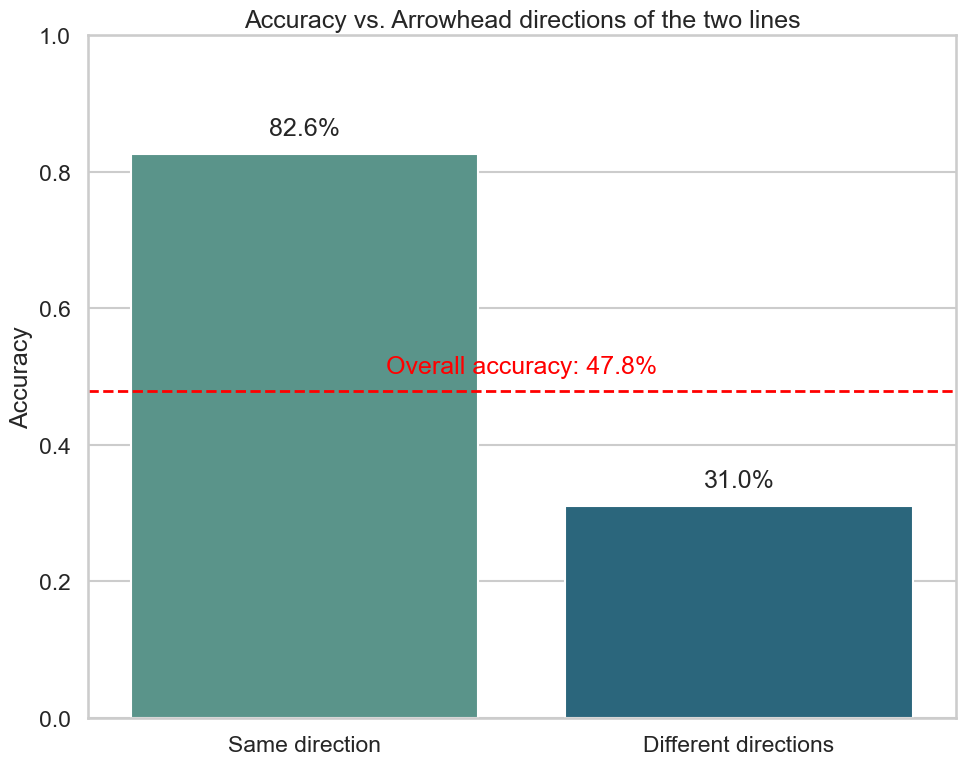

C:\Users\dongn\AppData\Local\Temp\ipykernel_15420\1714356766.py:73: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=by_top, x='top_dir', y='Accuracy',


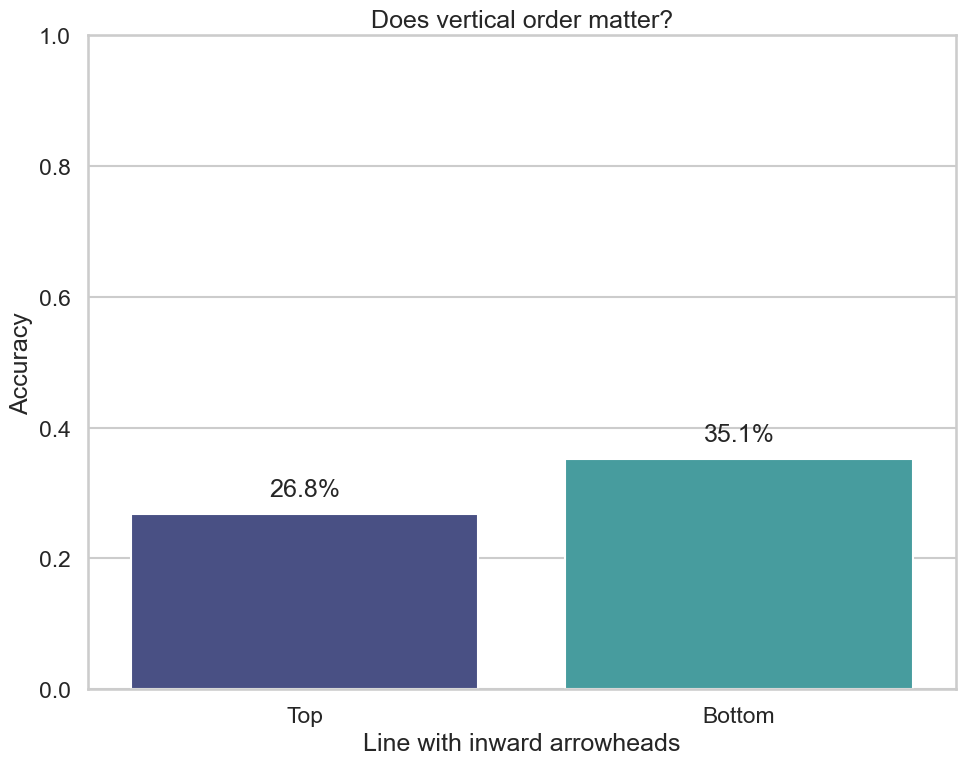

C:\Users\dongn\AppData\Local\Temp\ipykernel_15420\1714356766.py:95: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=by_fin, x='fin_case', y='Accuracy',


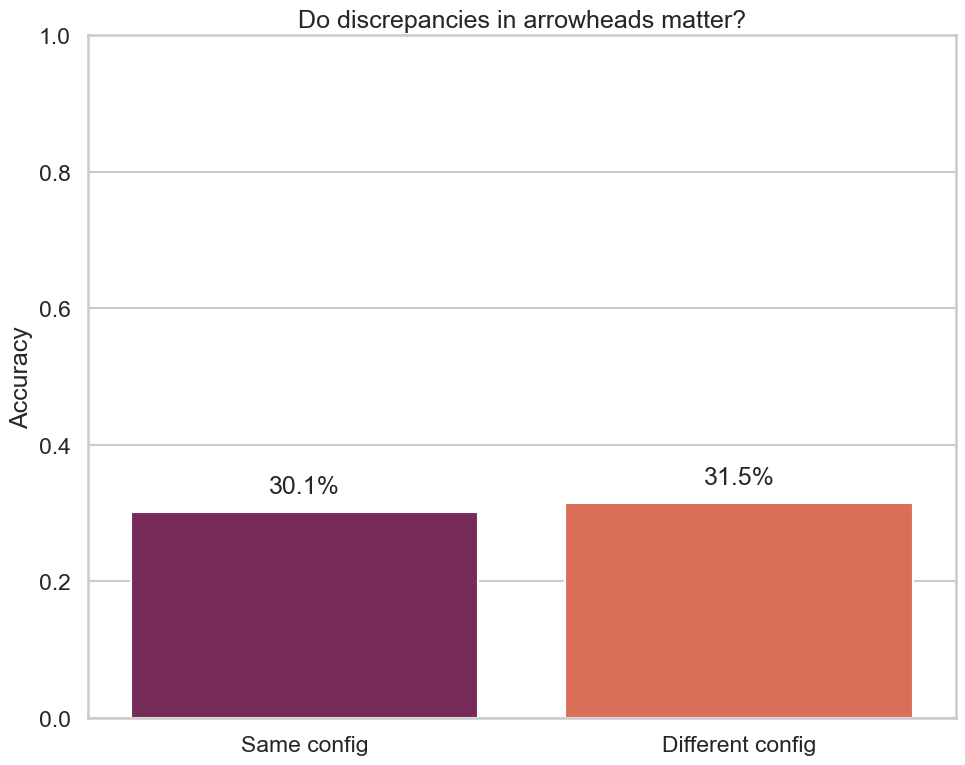

C:\Users\dongn\AppData\Local\Temp\ipykernel_15420\1714356766.py:111: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby('bin')['prediction']
C:\Users\dongn\AppData\Local\Temp\ipykernel_15420\1714356766.py:119: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=table, x='bin', y='Accuracy', palette='viridis', ax=ax)



Accuracy by Shaft Length
              bin  Accuracy
0  (44.999, 79.0]  0.038136
1   (79.0, 109.0]  0.152809
2  (109.0, 143.0]  0.219828
3  (143.0, 174.0]  0.383117
4  (174.0, 204.0]  0.732426


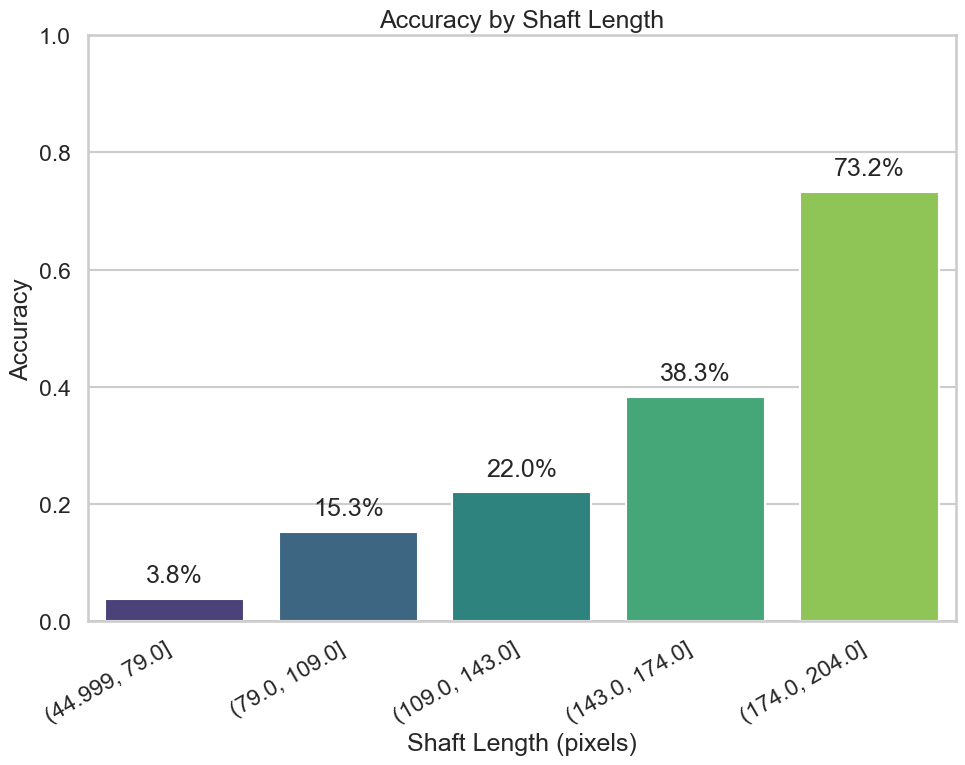

C:\Users\dongn\AppData\Local\Temp\ipykernel_15420\1714356766.py:111: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby('bin')['prediction']
C:\Users\dongn\AppData\Local\Temp\ipykernel_15420\1714356766.py:119: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=table, x='bin', y='Accuracy', palette='viridis', ax=ax)



Accuracy by Fin Length
              bin  Accuracy
0  (14.999, 17.0]  0.305709
1    (17.0, 20.0]  0.327059
2    (20.0, 24.0]  0.304147
3    (24.0, 29.0]  0.300000
4    (29.0, 35.0]  0.267773


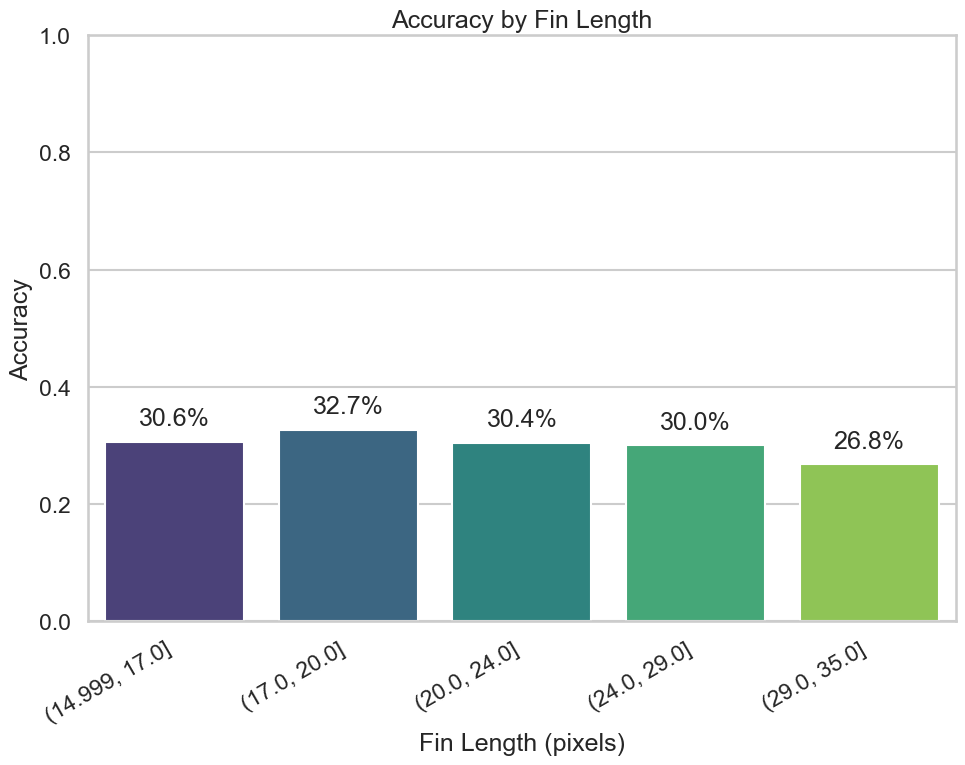


Accuracy by Fin Angle
              bin  Accuracy
0  (14.999, 26.0]  0.312227
1    (26.0, 39.0]  0.225941
2    (39.0, 51.0]  0.198198
3    (51.0, 63.0]  0.314159
4    (63.0, 75.0]  0.457965


C:\Users\dongn\AppData\Local\Temp\ipykernel_15420\1714356766.py:111: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby('bin')['prediction']
C:\Users\dongn\AppData\Local\Temp\ipykernel_15420\1714356766.py:119: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=table, x='bin', y='Accuracy', palette='viridis', ax=ax)


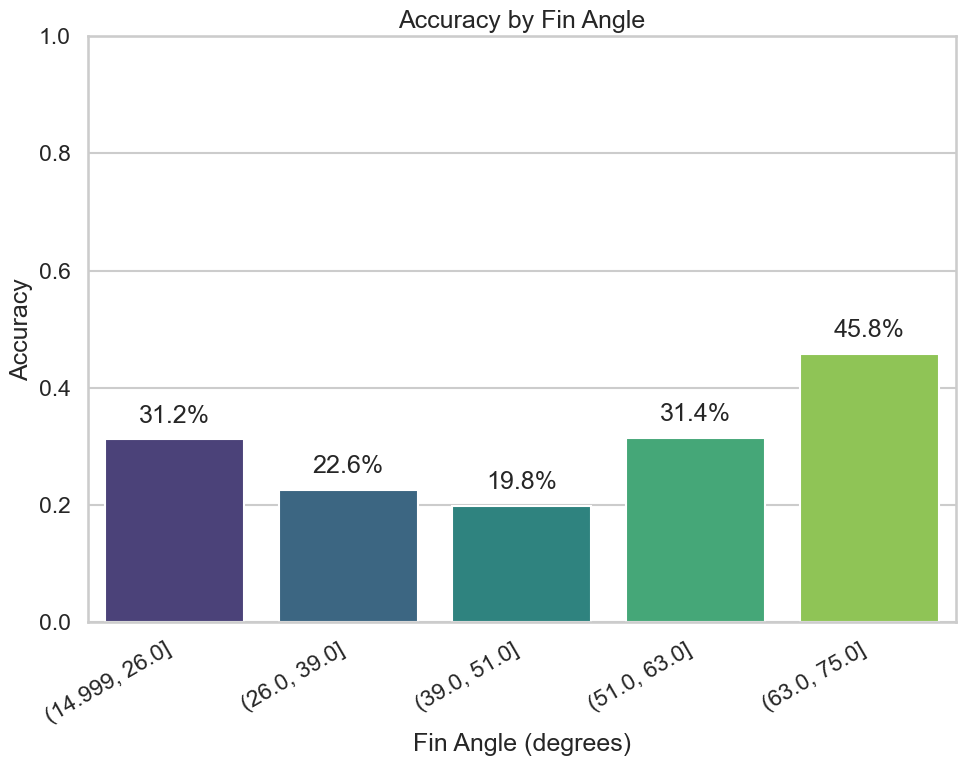

C:\Users\dongn\AppData\Local\Temp\ipykernel_15420\1714356766.py:111: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby('bin')['prediction']
C:\Users\dongn\AppData\Local\Temp\ipykernel_15420\1714356766.py:119: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=table, x='bin', y='Accuracy', palette='viridis', ax=ax)



Accuracy by Vertical Distance
              bin  Accuracy
0  (51.999, 83.0]  0.310273
1    (83.0, 97.0]  0.302174
2   (97.0, 108.0]  0.280172
3  (108.0, 121.0]  0.294664
4  (121.0, 153.0]  0.318584


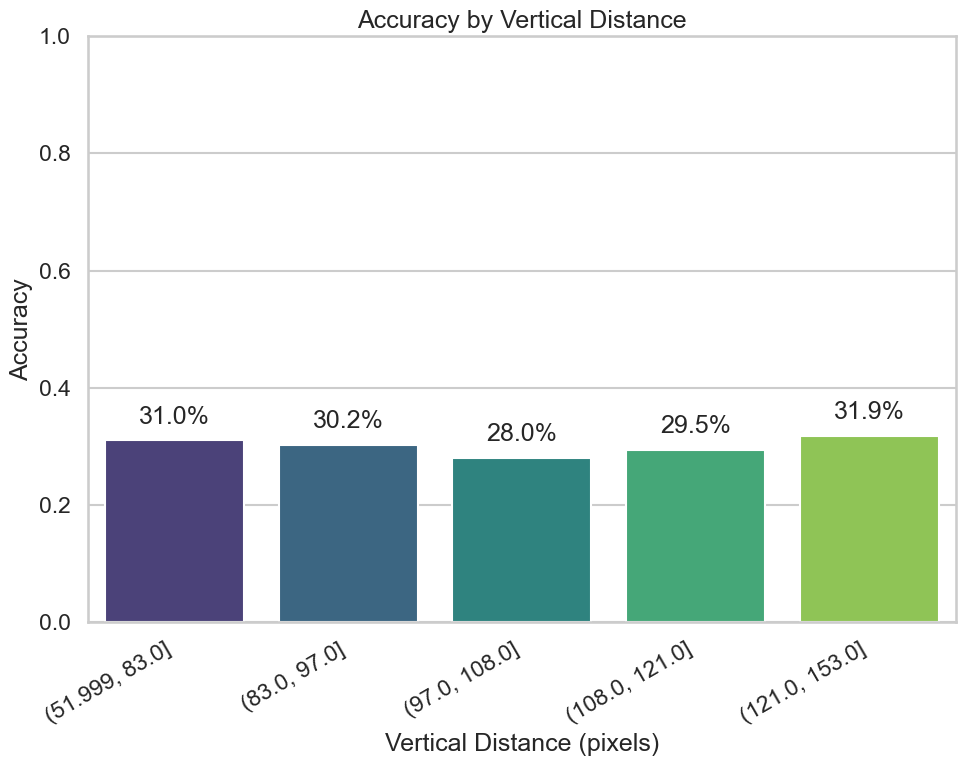


--- Analysis Pipeline Complete ---


In [ ]:
sns.set_theme(style="whitegrid")
sns.set_context("talk")

df = pd.DataFrame(params)
df['prediction'] = preds
df['vert_dist'] = df['bottom_y'] - df['top_y']

# 1) Overall % predicted zero
overall_p0 = np.mean(df['prediction'] == 0)
print(f"\n1) Overall % predicted zero: {overall_p0:.2%}")

def annotate_bars(ax, fmt="{:.1%}", y_offset=0.02):
    for p in ax.patches:
        h = p.get_height()
        ax.annotate(fmt.format(h),
                    (p.get_x()+p.get_width()/2, h + y_offset),
                    ha='center', va='bottom')

# 2) Accuracy vs. Arrowhead directions of the two lines 
overall_p0 = np.mean(df['prediction'] == 0)

by_bottom = (
    df.groupby('bottom_dir')['prediction']
      .apply(lambda x: np.mean(x==0))
      .reindex(['SAME_DIR','DIFF_DIR'])
      .reset_index(name='Accuracy')
)
by_bottom['bottom_dir'] = by_bottom['bottom_dir'].map({
    'SAME_DIR': 'Same direction',
    'DIFF_DIR': 'Different directions'
})

fig, ax = plt.subplots(figsize=(10,8))
sns.barplot(data=by_bottom, x='bottom_dir', y='Accuracy',
            palette='crest', ax=ax)

# overall accuracy 
ax.axhline(overall_p0, color='red', linestyle='--', linewidth=2)
ax.text(0.5, overall_p0 + 0.02,
        f"Overall accuracy: {overall_p0:.1%}",
        color='red', ha='center', va='bottom', fontsize='medium')

ax.set(ylim=(0,1),
       title="Accuracy vs. Arrowhead directions of the two lines",
       xlabel="",
       ylabel="Accuracy")
annotate_bars(ax)

plt.tight_layout()
plt.show()

# 3) Is illusion order-specific? (DIFF_DIR only)
diff = df[df['bottom_dir']=='DIFF_DIR']
by_top = (
    diff.groupby('top_dir')['prediction']
        .apply(lambda x: np.mean(x==0))
        .reindex(['LONG','SHORT'])
        .reset_index(name='Accuracy')
)
by_top['top_dir'] = by_top['top_dir'].map({
    'LONG': 'Top',
    'SHORT': 'Bottom'
})

fig, ax = plt.subplots(figsize=(10, 8))
sns.barplot(data=by_top, x='top_dir', y='Accuracy',
            palette='mako', ax=ax)
ax.set(ylim=(0,1), title="Does vertical order matter?")
ax.set_xlabel("Line with inward arrowheads")
ax.set_ylabel("Accuracy")
annotate_bars(ax)
plt.tight_layout()
plt.show()

# 4) Do discrepancies in arrow heads between the two lines matter?
by_fin = (
    diff.groupby('fin_case')['prediction']
        .apply(lambda x: np.mean(x==0))
        .reindex(['SAME_CONFIG','DIFF_CONFIG'])
        .reset_index(name='Accuracy')
)
by_fin['fin_case'] = by_fin['fin_case'].map({
    'SAME_CONFIG': 'Same config',
    'DIFF_CONFIG': 'Different config'
})

fig, ax = plt.subplots(figsize=(10,8))
sns.barplot(data=by_fin, x='fin_case', y='Accuracy',
            palette='rocket', ax=ax)
ax.set(ylim=(0,1), title="Do discrepancies in arrowheads matter?")
ax.set_xlabel("")  # no x-label
ax.set_ylabel("Accuracy")
annotate_bars(ax)
plt.tight_layout()
plt.show()

# 5) DIFF_DIR & SAME_CONFIG: continuous-variable effects
subset = diff[diff['fin_case']=='SAME_CONFIG']

def plot_continuous(var, bins, title, xlabel):
    binned = pd.qcut(subset[var], q=bins, duplicates='drop')
    table = (
        subset.assign(bin=binned)
              .groupby('bin')['prediction']
              .apply(lambda x: np.mean(x==0))
              .reset_index(name='Accuracy')
    )
    print(f"\n{title}")
    print(table)

    fig, ax = plt.subplots(figsize=(10,8))
    sns.barplot(data=table, x='bin', y='Accuracy', palette='viridis', ax=ax)
    ax.set(ylim=(0,1), title=title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel("Accuracy")
    plt.setp(ax.get_xticklabels(), rotation=30, ha='right')
    annotate_bars(ax)
    plt.tight_layout()
    plt.show()

plot_continuous('shaft_len',    5,
                "Accuracy by Shaft Length",
                "Shaft Length (pixels)")
plot_continuous('top_fin_len',  5,
                "Accuracy by Fin Length",
                "Fin Length (pixels)")
plot_continuous('top_fin_ang',  5,
                "Accuracy by Fin Angle",
                "Fin Angle (degrees)")
plot_continuous('vert_dist',    5,
                "Accuracy by Vertical Distance",
                "Vertical Distance (pixels)")

print("\n--- Analysis Pipeline Complete ---")


C:\Users\dongn\AppData\Local\Temp\ipykernel_13120\1618337949.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=by_fin_same, x='fin_case', y='Accuracy',


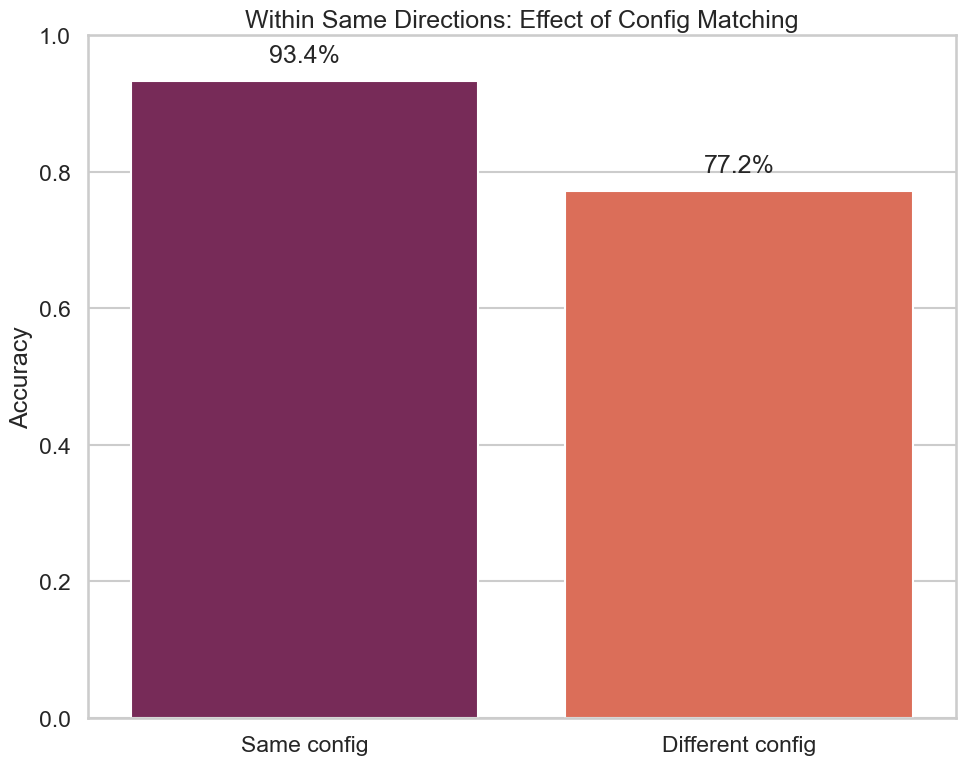

In [ ]:
same = df[df['bottom_dir']=='SAME_DIR']

by_fin_same = (
    same.groupby('fin_case')['prediction']
        .apply(lambda x: np.mean(x == 0))
        .reindex(['SAME_CONFIG','DIFF_CONFIG'])
        .reset_index(name='Accuracy')
)

by_fin_same['fin_case'] = by_fin_same['fin_case'].map({
    'SAME_CONFIG': 'Same config',
    'DIFF_CONFIG': 'Different config'
})

fig, ax = plt.subplots(figsize=(10,8))
sns.barplot(data=by_fin_same, x='fin_case', y='Accuracy',
            palette='rocket', ax=ax)

ax.set(ylim=(0,1),
       title="Within Same Directions: Effect of Config Matching",
       xlabel="", 
       ylabel="Accuracy")

for p in ax.patches:
    ax.annotate(f"{p.get_height():.1%}",
                (p.get_x()+p.get_width()/2, p.get_height()+0.02),
                ha='center', va='bottom')

plt.tight_layout()
plt.show()


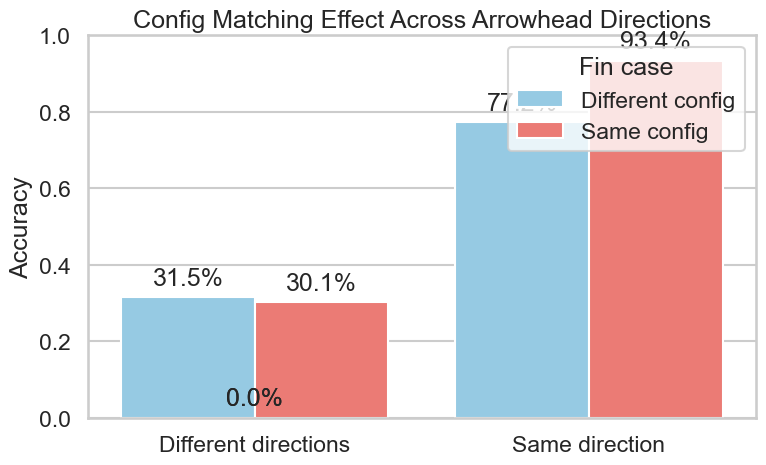

In [ ]:
config_acc = (
    df
    .groupby(['bottom_dir','fin_case'])['prediction']
    .apply(lambda x: np.mean(x == 0))
    .reset_index(name='Accuracy')
)

config_acc['bottom_dir'] = config_acc['bottom_dir'].map({
    'SAME_DIR': 'Same direction',
    'DIFF_DIR': 'Different directions'
})
config_acc['fin_case'] = config_acc['fin_case'].map({
    'SAME_CONFIG': 'Same config',
    'DIFF_CONFIG': 'Different config'
})

fig, ax = plt.subplots(figsize=(8,5))
sns.barplot(data=config_acc,
            x='bottom_dir',
            y='Accuracy',
            hue='fin_case',
            palette=['#89CFF0','#FF6961'],  # two distinct colors
            ax=ax)

ax.set(ylim=(0,1),
       title="Config Matching Effect Across Arrowhead Directions",
       xlabel="", 
       ylabel="Accuracy")

ax.legend(title="Fin case", loc='upper right')

for p in ax.patches:
    h = p.get_height()
    ax.annotate(f"{h:.1%}",
                (p.get_x() + p.get_width()/2, h + 0.02),
                ha='center', va='bottom')

plt.tight_layout()
plt.show()


## more analysis

In [160]:
import pandas as pd
df = pd.read_csv("extraction_results/parameters.csv")
preds = np.load("extraction_results/predictions.npy")
df['prediction'] = preds
df['correct'] = df.prediction == df.label

df.head()

,index,label,top_dir,bottom_dir,fin_case,shaft_len,top_fin_len,top_fin_ang,bot_fin_len,bot_fin_ang,top_y,bottom_y,filename,prediction,correct
0,0,1,LONG,DIFF_DIR,DIFF_CONFIG,136,18,51,31,24,99,159,ml_0_1_LONG_DIFF_DIR_DIFF_CONFIG_136_18_51_31_...,0,False
1,1000,1,SHORT,DIFF_DIR,SAME_CONFIG,195,29,73,29,73,52,164,ml_1000_1_SHORT_DIFF_DIR_SAME_CONFIG_195_29_73...,0,False
2,1001,1,SHORT,DIFF_DIR,DIFF_CONFIG,183,15,74,18,18,55,176,ml_1001_1_SHORT_DIFF_DIR_DIFF_CONFIG_183_15_74...,0,False
3,1002,1,LONG,SAME_DIR,DIFF_CONFIG,104,32,51,27,44,62,191,ml_1002_1_LONG_SAME_DIR_DIFF_CONFIG_104_32_51_...,0,False
4,1003,1,SHORT,DIFF_DIR,DIFF_CONFIG,64,18,25,16,46,54,161,ml_1003_1_SHORT_DIFF_DIR_DIFF_CONFIG_64_18_25_...,1,True


C:\Users\dongn\AppData\Local\Temp\ipykernel_15420\521721688.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=imp_df.values[:10], y=imp_df.index[:10], palette='mako')


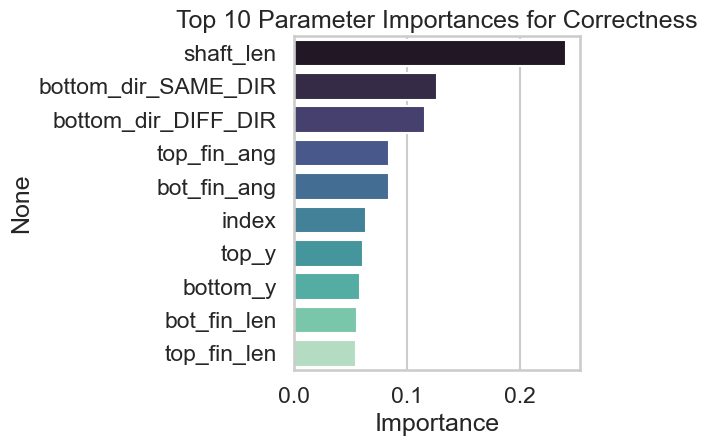

In [165]:
from sklearn.ensemble import RandomForestClassifier
importances = RandomForestClassifier(n_estimators=100, random_state=0) \
    .fit(pd.get_dummies(df.drop(columns=['filename','prediction','correct','label'])), 
         df['correct']) \
    .feature_importances_
feat_names = pd.get_dummies(df.drop(columns=['filename','prediction','correct','label'])).columns
imp_df = pd.Series(importances, index=feat_names).sort_values(ascending=False)
sns.barplot(x=imp_df.values[:10], y=imp_df.index[:10], palette='mako')
plt.title("Top 10 Parameter Importances for Correctness"); plt.xlabel("Importance"); plt.tight_layout()

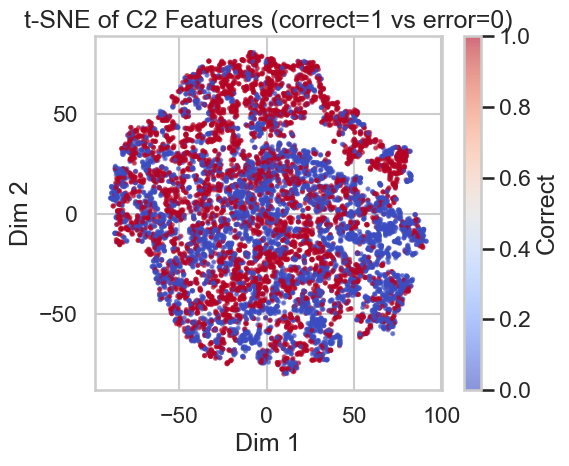

In [ ]:
from sklearn.manifold    import TSNE

features = np.load("extraction_results/features.npy")

tsne2 = TSNE(n_components=2, random_state=0, init='pca').fit_transform(features)
plt.figure(figsize=(6,5))
plt.scatter(tsne2[:,0], tsne2[:,1], c=df['correct'], cmap='coolwarm', s=5, alpha=0.6)
plt.title("t-SNE of C2 Features (correct=1 vs error=0)")
plt.xlabel("Dim 1"); plt.ylabel("Dim 2")
plt.colorbar(label="Correct")
plt.tight_layout()
plt.show()

In [ ]:
def compute_occlusion_map(
    img_pil, hmax_model, svm, device,
    transform, patch_size=32, stride=16
):
    x0 = transform(img_pil).unsqueeze(0).to(device)      # [1, C, H, W]
    feats0 = hmax_model(x0).view(1, -1).cpu().numpy()    # [1, D]
    base_score = float(svm.decision_function(feats0))   # scalar

    W, H = img_pil.size
    sal = np.zeros((H, W), dtype=np.float32)

    for y in range(0, H, stride):
        for x in range(0, W, stride):
            img_occ = img_pil.copy()
            patch = Image.new("L", (patch_size, patch_size), 128)
            img_occ.paste(patch, (x, y))

            x1 = transform(img_occ).unsqueeze(0).to(device)
            feats1 = hmax_model(x1).view(1, -1).cpu().numpy()
            occ_score = float(svm.decision_function(feats1))

            sal[y: y+patch_size, x: x+patch_size] = base_score - occ_score

    sal = np.clip(sal, 0, None)
    if sal.max() > 0:
        sal /= sal.max()
    return sal


C:\Users\dongn\AppData\Local\Temp\ipykernel_15420\4218960716.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  base_score = float(svm.decision_function(feats0))   # scalar
C:\Users\dongn\AppData\Local\Temp\ipykernel_15420\4218960716.py:30: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  occ_score = float(svm.decision_function(feats1))
C:\Users\dongn\AppData\Local\Temp\ipykernel_15420\4218960716.py:30: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  occ_score = float

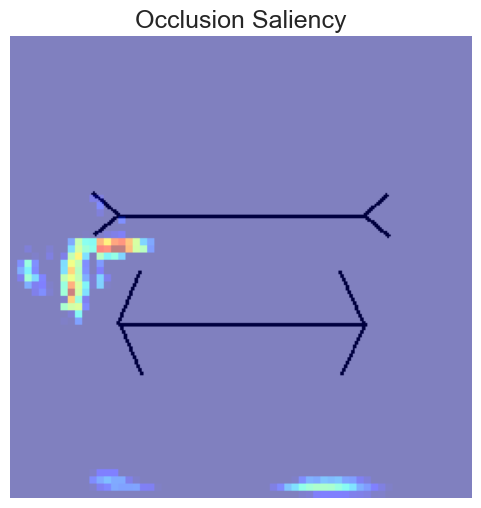

In [ ]:
img_path = r"S:\coding\neur140\final_project\test_data\ml_0_1_LONG_DIFF_DIR_DIFF_CONFIG_136_18_51_31_24_99_159.png"

img = Image.open(img_path).convert("L")

heat = compute_occlusion_map(
    img,
    hmax_model,
    svm_model,
    device,
    transform=data_transform,
    patch_size=32,
    stride=4
)

plt.figure(figsize=(6,6))
plt.imshow(img, cmap='gray')
plt.imshow(heat, cmap='jet', alpha=0.5)
plt.axis('off')
plt.title("Occlusion Saliency")
plt.show()

100%|██████████| 300/300 [01:03<00:00,  4.74it/s]


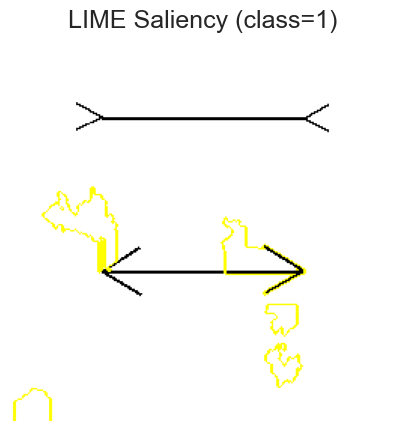

In [ ]:
from lime import lime_image
from skimage.segmentation import mark_boundaries

gray = Image.open(img_path).convert("L").resize((IMG_SIZE, IMG_SIZE))
arr  = np.array(gray)                                 # H×W, 0–255
img_rgb = np.stack([arr, arr, arr], axis=2).astype(np.uint8)  # H×W×3

def predict_fn(images_np):
    out = []
    for im in images_np:
        im_gray = Image.fromarray(im).convert("L")
        x = data_transform(im_gray).unsqueeze(0).to(device)
        feats = hmax_model(x).view(1, -1).cpu().numpy()
        score = svm_model.decision_function(feats)[0]
        out.append([ -score, score ])
    return np.array(out)

explainer = lime_image.LimeImageExplainer()
exp = explainer.explain_instance(
    image=img_rgb,      
    classifier_fn=predict_fn,
    top_labels=1,        
    hide_color=0,
    num_samples=300
)

temp, mask = exp.get_image_and_mask(
    label=1,
    positive_only=True,
    num_features=5,
    hide_rest=False
)

plt.figure(figsize=(5,5))
plt.imshow(mark_boundaries(temp/255.0, mask))
plt.axis('off')
plt.title("LIME Saliency (class=1)")
plt.show()
